In [1]:
!uv pip install pillow boto3 pillow -q 

In [4]:
import boto3
import glob
from PIL import Image   
import re
import pandas as pd
from dotenv import load_dotenv
from IPython.display import display
load_dotenv()

True

In [7]:
rekognition_client = boto3.client('rekognition')

## Setup and Imports

First, let's gather all our imports and set up the necessary clients and constants. We'll also add a list of common car makes to search for.

In [5]:
# List of car makes to search for (already uppercase)
car_makes = [
    'TOYOTA', 'HONDA', 'FORD', 'CHEVROLET', 'NISSAN', 'JEEP', 'HYUNDAI', 'KIA',
    'SUBARU', 'RAM', 'GMC', 'BMW', 'MERCEDES-BENZ', 'LEXUS', 'AUDI', 'VOLKSWAGEN',
    'TESLA', 'ACURA', 'CADILLAC', 'CHRYSLER', 'DODGE', 'INFINITI', 'LINCOLN', 'MAZDA'
]

# List of full US state names for searching
us_state_names = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]

### Call AWS Rekognition and Display Raw Results

This cell will loop through your images, call the `detect_text` API, and store the raw results. Displaying the image and the detected text helps students see exactly what data we're working with before processing it.

## Let's understand how AWS Rekognition works for text detection
* First, we use the with open(...) statement to handle the image file. This is the recommended way to work with files in Python because it automatically takes care of closing the file once you are done with it.
* We specify the mode as 'rb', which stands for read-binary. This is essential because images are not simple text files; they are complex structures of binary data (bytes). Reading in this mode ensures the data is not misinterpreted or corrupted.
* Next, we call the detect_text method on the rekognition_client object. This client is part of the AWS Boto3 library and acts as the interface to the Amazon Rekognition service.
* When calling detect_text, we pass a parameter named Image. This parameter must be a dictionary that tells Rekognition where to find the image to analyze.
    * Inside this dictionary, we use the key 'Bytes'. This tells Rekognition that we are providing the image data directly as a stream of bytes, rather than pointing to an image stored in an S3 bucket.
    * The value for the 'Bytes' key is provided by image_file.read(). This command reads the entire content of the opened image file into memory as binary data.

In [12]:
with open('images/1c00790f8e592ab2.jpg', 'rb') as image_file:
    response = rekognition_client.detect_text(Image={'Bytes': image_file.read()})
response

{'TextDetections': [{'DetectedText': 'VA 4713476',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 98.74816131591797,
   'Geometry': {'BoundingBox': {'Width': 0.06736516952514648,
     'Height': 0.0341796875,
     'Left': 0.8404541015625,
     'Top': 0.169921875},
    'Polygon': [{'X': 0.8404541015625, 'Y': 0.169921875},
     {'X': 0.9078192710876465, 'Y': 0.169921875},
     {'X': 0.9078192710876465, 'Y': 0.2041015625},
     {'X': 0.8404541015625, 'Y': 0.2041015625}]}},
  {'DetectedText': 'VA 5278850',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 99.54822540283203,
   'Geometry': {'BoundingBox': {'Width': 0.11568643152713776,
     'Height': 0.0439453125,
     'Left': 0.1796264499425888,
     'Top': 0.2001953125},
    'Polygon': [{'X': 0.1796264499425888, 'Y': 0.2001953125},
     {'X': 0.29531288146972656, 'Y': 0.2001953125},
     {'X': 0.29531288146972656, 'Y': 0.244140625},
     {'X': 0.1796264499425888, 'Y': 0.244140625}]}},
  {'DetectedText': 'VIRGINIA',
   'Type': 'LINE',
   'Id

We will focus on the `TextDetections` section

In [13]:
response['TextDetections']

[{'DetectedText': 'VA 4713476',
  'Type': 'LINE',
  'Id': 0,
  'Confidence': 98.74816131591797,
  'Geometry': {'BoundingBox': {'Width': 0.06736516952514648,
    'Height': 0.0341796875,
    'Left': 0.8404541015625,
    'Top': 0.169921875},
   'Polygon': [{'X': 0.8404541015625, 'Y': 0.169921875},
    {'X': 0.9078192710876465, 'Y': 0.169921875},
    {'X': 0.9078192710876465, 'Y': 0.2041015625},
    {'X': 0.8404541015625, 'Y': 0.2041015625}]}},
 {'DetectedText': 'VA 5278850',
  'Type': 'LINE',
  'Id': 1,
  'Confidence': 99.54822540283203,
  'Geometry': {'BoundingBox': {'Width': 0.11568643152713776,
    'Height': 0.0439453125,
    'Left': 0.1796264499425888,
    'Top': 0.2001953125},
   'Polygon': [{'X': 0.1796264499425888, 'Y': 0.2001953125},
    {'X': 0.29531288146972656, 'Y': 0.2001953125},
    {'X': 0.29531288146972656, 'Y': 0.244140625},
    {'X': 0.1796264499425888, 'Y': 0.244140625}]}},
 {'DetectedText': 'VIRGINIA',
  'Type': 'LINE',
  'Id': 2,
  'Confidence': 98.68757629394531,
  'G

Notice, that inside the list we have a dictionary for each text detected this includes:
* __DetectedText__: This key holds the actual string of text that the Rekognition service identified in the image. For example, 'APR California' and '6UVM976'.
* __Type__: This specifies the level of detection. The API returns results for both LINE and WORD.
    * A LINE is a sequence of co-linear words, like a sentence or a license plate number.
    * A WORD is a single word that is part of a line. The full response from Rekognition would also show the individual words 'APR' and 'California' with a Type of 'WORD', and they would include a ParentId linking them back to the LINE with Id: 0.
* __Confidence__: This is a floating-point number between 0 and 100 that represents how confident the machine learning model is in the accuracy of its detection. For instance, 99.34 indicates a very high level of confidence that the text is indeed '6UVM976'.
* __Geometry__: This is an object that contains detailed information about the physical position and size of the detected text on the image. It has two parts:
    * `BoundingBox`: This provides the coordinates for a simple rectangle that encloses the text. The Width, Height, Left (x-coordinate of the top-left corner), and Top (y-coordinate of the top-left corner) values are given as ratios of the total image dimensions. This relative sizing means the values are independent of the image's resolution.
    * `Polygon`: This provides a more precise outline of the text by giving the X and Y coordinates for each corner of a polygon surrounding the text. This is particularly useful for text that is rotated or not perfectly horizontal.

### LINE vs WORD 

In [14]:
for text in response['TextDetections']:
    if text['Type'] == 'WORD':
        print(f"Detected Text: {text['DetectedText']}")
        print(f"Confidence: {text['Confidence']:.2f}%")
        print("-" * 40)

Detected Text: VA
Confidence: 99.10%
----------------------------------------
Detected Text: 4713476
Confidence: 98.39%
----------------------------------------
Detected Text: VA
Confidence: 100.00%
----------------------------------------
Detected Text: 5278850
Confidence: 99.10%
----------------------------------------
Detected Text: VIRGINIA
Confidence: 98.69%
----------------------------------------
Detected Text: 16
Confidence: 99.74%
----------------------------------------
Detected Text: AUG
Confidence: 100.00%
----------------------------------------
Detected Text: OPA
Confidence: 95.88%
----------------------------------------
Detected Text: OPA
Confidence: 92.74%
----------------------------------------
Detected Text: VIRGINIA
Confidence: 99.41%
----------------------------------------
Detected Text: IS
Confidence: 99.43%
----------------------------------------
Detected Text: FOR
Confidence: 99.67%
----------------------------------------
Detected Text: LOVERS
Confidence: 96

In [15]:
for text in response['TextDetections']:
    if text['Type'] == 'LINE':
        print(f"Detected Text: {text['DetectedText']}")
        print(f"Confidence: {text['Confidence']:.2f}%")
        print("-" * 40)

Detected Text: VA 4713476
Confidence: 98.75%
----------------------------------------
Detected Text: VA 5278850
Confidence: 99.55%
----------------------------------------
Detected Text: VIRGINIA
Confidence: 98.69%
----------------------------------------
Detected Text: 16
Confidence: 99.74%
----------------------------------------
Detected Text: AUG
Confidence: 100.00%
----------------------------------------
Detected Text: OPA
Confidence: 95.88%
----------------------------------------
Detected Text: OPA
Confidence: 92.74%
----------------------------------------
Detected Text: VIRGINIA IS FOR LOVERS
Confidence: 98.78%
----------------------------------------
Detected Text: Virginia.org
Confidence: 97.79%
----------------------------------------


## Call AWS Rekognition and Display Raw Results

This cell will loop through your images, call the detect_text API, and store the raw results. Displaying the image and the detected text helps students see exactly what data we're working with before processing it.

* `glob.glob('images/*')`: Finds all files in the images folder and returns their paths as a list.
* `for image_path in image_paths:`: Loops through each image file path collected in the previous step to process them one by one.
* `with open(image_path, 'rb') as image_file:`: Opens the current image file in read-binary mode, ensuring it's properly closed afterward.
* `rekognition_client.detect_text(...)`: Sends the image's binary data to the AWS Rekognition API to perform text detection.
* `[item['DetectedText'] for item in ...]`: Extracts only the detected text strings from the complex JSON response returned by the API.
* `rekognition_output.append({...})`: Stores the image's name and the simplified list of detected text into a structured list.
* `Image.open(image_path)` and `display(image)`: Opens, resizes, and displays the current image being processed for visual confirmation.

Found 3 images to process...



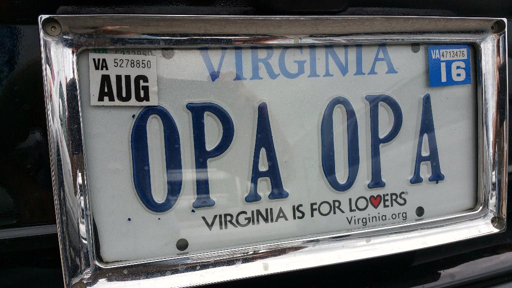

Image: 1c00790f8e592ab2.jpg
Detected Text: ['VA', '4713476', 'VA', '5278850', 'VIRGINIA', '16', 'AUG', 'OPA', 'OPA', 'VIRGINIA', 'IS', 'FOR', 'LOVERS', 'Virginia.org']

----------------------------------------


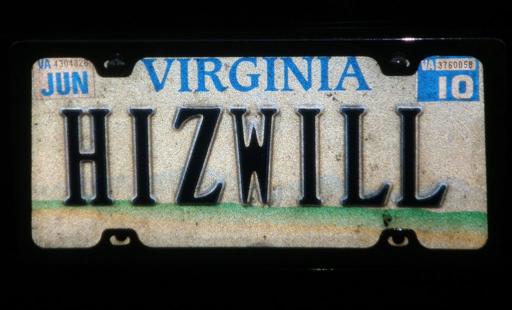

Image: 1d5b964bef140076.jpg
Detected Text: ['VA', '4304826', 'JUN', 'VIRGINIA', 'VA', '3760058', '10', 'HIZK', 'ILL']

----------------------------------------


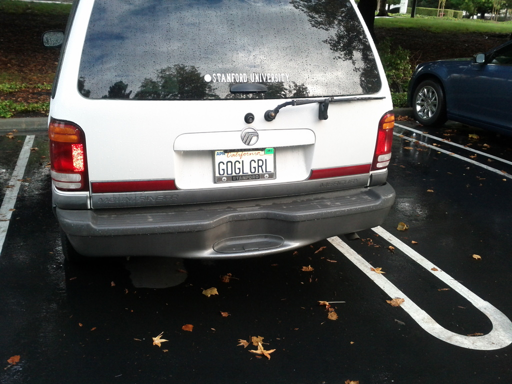

Image: 1c62dcbf9a6c22c7.jpg
Detected Text: ['STANFORD', 'UNIVERSITY', 'APR', '2013', 'California', 'GOGLGRL', 'STANPORD', 'MESCUR', 'MOUNTAINESS']

----------------------------------------


In [23]:
# List to store the raw output from Rekognition
rekognition_output = []
image_paths = glob.glob('images/*')

print(f"Found {len(image_paths)} images to process...\n")

for image_path in image_paths:
    with open(image_path, 'rb') as image_file:
        response = rekognition_client.detect_text(Image={'Bytes': image_file.read()})
    
    # Extract only the detected text strings
    detected_text = [item['DetectedText'] for item in response['TextDetections'] if item['Type'] == 'WORD']
    
    rekognition_output.append({
        'image_name': image_path.split('/')[-1], # Get just the filename
        'labels': detected_text
    })
    
    # Display the image scaled to 50% for review
    image = Image.open(image_path)
    image.thumbnail((image.width * 0.5, image.height * 0.5)) # Preserves aspect ratio
    display(image)
    
    print(f"Image: {image_path.split('/')[-1]}")
    print(f"Detected Text: {detected_text}\n")
    print("-" * 40)

In [59]:
rekognition_output

[{'image_name': '37a515312eca1d5a.jpg',
  'labels': ['Minaret',
   'Road',
   'IMBIGO',
   'JUN',
   'California',
   'SHE',
   '6WJX062',
   'BEFEND',
   'AUTHENTICITY',
   'FRS',
   '©Mato']},
 {'image_name': '314a92443055fcb4.jpg',
  'labels': ['-', 'MICHIGAN', '-', 'BAH', '5090', '***Michigan']},
 {'image_name': '2c75228218b9f9c5.jpg',
  'labels': ['PHYSICAL',
   '...',
   '11',
   'LA',
   'ILLA',
   'Aa',
   '358.353',
   'the',
   'sammo',
   'OC',
   'California',
   '2018',
   '6KBM178',
   'DAMIAN',
   'MORYS',
   'PHOTOGRAPHY',
   '2010']},
 {'image_name': 'f484d1b789e6ed63.jpg',
  'labels': ['VA',
   '4650813',
   'MAR',
   'VIRGINIA',
   'VA',
   '0865455',
   'PY1TFWD',
   '14']},
 {'image_name': '34648969fa39542f.jpg',
  'labels': ['VA',
   '4732814',
   'VIRGINIA',
   'VA',
   '4257893',
   '14',
   'JUN',
   'ZYXWYUT']},
 {'image_name': '29ab3cf353e1f894.jpg',
  'labels': ['TEXAS',
   'DWV',
   '6485',
   'SSEY',
   'Howdy',
   'HONDA',
   'ELITE',
   'SWAGGER',
   'WA

## Process Raw Data and Extract Information

Now we'll loop through the `rekognition_output` we just created. 


In [17]:
processed_data = []

# Loop through the raw data we collected from Rekognition
for item in rekognition_output:
    image_name = item['image_name']
    
    # Use the correct key 'labels' to access the list of words.
    full_text = " ".join(item['labels']).upper()
    
    found_make = None
    found_state = None
    
    # --- Find Car Make ---
    for make in car_makes:
        if make in full_text:
            found_make = make.title()
            break 
            
    # --- Find State Name ---
    for state_name in us_state_names:
        if state_name.upper() in full_text:
            found_state = state_name
            break

    # Add the extracted info to our list
    processed_data.append({
        'image_name': image_name,
        'make': found_make,
        'state': found_state
    })

print("Data processing complete.")
# Now, you can run your final cell to create the DataFrame!

Data processing complete.


## Create and Display the Final DataFrame

The last step is to convert our list of results into a clean, easy-to-read pandas DataFrame.

In [18]:
# Create the DataFrame from our list of processed dictionaries
df = pd.DataFrame(processed_data)

# For better presentation, replace Python's 'None' with a 'Not Found' string
df.fillna('Not Found', inplace=True)

print("Final DataFrame:")
display(df)

Final DataFrame:


,image_name,make,state
0,1c00790f8e592ab2.jpg,Not Found,Virginia
1,1d5b964bef140076.jpg,Not Found,Virginia
2,1c62dcbf9a6c22c7.jpg,Ford,California
